#  Assignment 4

## Notebook made by  

|** Name** | **Student id** | **email**|
|:- |:-|:-|
|. | | |
|  | |. |

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. 

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src='link to your selfie'/>

### Note
* **Assignments without the selfies or completely filled in information will not be graded and receive 0 points.**


# P1 Parsing wikipedia

#### Hints: 
1. Gebruik de code uit `ParseWikipediaDump.ipynb` in de NoteBook folder.
2. Ontwikkel voor opgave 2:
    * eerst een versie met alleen pageid, titel en aantal woorden
    * ontwikkel de "sectie-extractor" apart op een stukje test file
    * voeg de sectie-extractor dan in je eerdere code in.


#### Opgaven
1. Haal de laatste NL wikipedia dump op van <https://dumps.wikimedia.org/nlwiki/20160111/>. **update: dit is van een eerder jaar. Verwijder de datum uit de URL, kijke wat je krijgt,  en klik op de laatste datum. Wij werken in 2017 met <https://dumps.wikimedia.org/nlwiki/20170301/>**  Je hebt de file <https://dumps.wikimedia.org/nlwiki/20160111/nlwiki-20160111-pages-articles.xml.bz2> nodig, maar kunt als je dat wat groot vindt eerst beginnen met <https://dumps.wikimedia.org/nlwiki/20160111/nlwiki-20160111-pages-articles1.xml.bz2>
2. We gaan een dataframe maken met informatie over **elke** pagina in de NL wikipedia. Dit dataframe bevat voor elke pagina de volgende 4 kolommen:
    1. page id (dit wordt de index)
    2. titel van de pagina
    3. het aantal secties  (dus geen subsecties en dergelijke)
    4. een lijst met alle namen van de secties.
    5. het aantal woorden op de pagina (geef duidelijk in woorden aan wat je hieronder verstaat).
2. Gebuik `%time` om te timen hoe lang je programma er over doet. Zorg dat dit duidelijk in je notebook staat. Laat ook zien hoe groot je bestand is. 
    * aantal regels, aantal kolommen, aantal cellen met missende data. 
3. Sla dit dataframe op als pickle bestand. Laat met een commando (denk aan magics) zien hoe groot het is in een voor mensen leesbare eenheid (dus niet in Bytes als het meerdere Mb groot is.
3. Sla je dataframe op als csv bestand en probeer het in te lezen in Word of Openoffice en in Google spreadsheets. Rapporteer exact wat er gebeurt.
4. Maak een plot waarin je op de x-as het aantal secties zet en op de y-as het aantal paginas met zoveel secties. Zorg dat het goed leesbaar is door eventueel een log schaal te gebruiken.
5. Bereken het gemiddeld aantal secties, de mediaan, en de standaard deviatie, en geef de titel van (een?) pagina met het maximale aantal secties, en geef dat maximale aantal natuurlijk. 
    * Hoeveel paginas hebben geen secties? 
    * Is dat dan een missing data (`NaN`) of `0`. Wat is eigenlijk het verschil?
6. Plot het aantal secties tegen het aantal woorden en bereken de correlatie.
7. Wat is het gemiddeld aantal woorden per sectie op NL Wikipedia?
    * Geef eerst een sluitende definitie in woorden van dit begrip. En programmeer die dan. Wees niet te snel blij en klaar. Dit is nog best tricky. 
8. **Sectie namen**
    1. Tel voor alle sectie titels hoe vaak ze voorkomen. Laat de top 10 meest voorkomende secties zien. 
    2. Plot de sectietitels (x-as) tegen hun count (y-as) in loglog style en ga na of dat min of meer een rechte lijn is. 
        * Zo ja, dan is dit hoogstwaarschijnlijk een _power law_ (ook wel _Zipf_-verdeling genoemd) verdeling.
        * Kan je verklaren waarom sectietitels powerlaw verdeeld zijn?

#### Hint
* Denk na of de waarden die je vind ergens op slaan.
* Het is echt niet voldoende dat je het commando `df.mean()` kent. Het is echt de bedoeling dat je nadenkt.

#### Voorbeeld
Voor <https://nl.wikipedia.org/wiki/Albert_Speer> ziet dit er (op dit moment van schrijven) als volgt uit:
1. page id is $1$
2. titel is _Albert Speer_
3. Aantal secties is 12
4. Sectie titels zijn (maar dan zonder de nummering)
```
1	Voor 1933
2	In dienst van Hitler
3	Speer de organisator
4	Hitlers laatste bevelen aan Speer
5	Arrestatie en gevangenisstraf
6	Speer als de 'nette nazi'
7	Nalatenschap
8	Het einde van de mythe
9	Wetenswaardig
10	Publicaties
11	Literatuur
12	Film
```


 
    
    

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import re
from lxml import etree 
from bz2file import BZ2File
import codecs
import nltk
import pickle

In [2]:
file_klein = '../nlwiki-20180301-pages-articles1.xml.bz2'
file_groot = ''
reference_extractor=r'[^=]={2}([^=]{1,})=='

In [3]:
def count_references(f,inset): # ,outfile):
    '''With f a wikipedia dump and inset a list of pageids, count for each page in the dump \cap inset the number of references
    on the page and return as a dict with pageid:reference_count key-value pairs.'''
    with BZ2File(f) as xml_file:
        context = etree.iterparse(xml_file,  tag= '{http://www.mediawiki.org/xml/export-0.10/}page')
        pages_dict={}
            
        c=0
        for _, elem in context:
            
                page_id = elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}id')
                try:  
                    page_id= int(page_id)
                    if  page_id in inset: # we only do this for pages in  inset
                        pagetitle= elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}title')
                        pagetext=elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}revision/{http://www.mediawiki.org/xml/export-0.10/}text')
                        
                        abc = len(nltk.tokenize.wordpunct_tokenize(pagetext))
                        refs= (re.findall(reference_extractor, pagetext))
                        ref_count= sum ( 1 for _ in refs)
                        
                        pages_dict[page_id] = [pagetitle, ref_count, refs, abc]
                        
                        #if page_id  and ref_count: # just store those with a count > 0
                        ##pages_references_dict[page_id]= ref_count 
                        # use this when you want to write away the results to file
                        #f.write(str(page_id)+';'+str(ref_count)+'\n')
                except:
                    True
                elem.clear()
                
                for ancestor in elem.xpath('ancestor-or-self::*'):
                    while ancestor.getprevious() is not None:
                        del ancestor.getparent()[0]    
                
                c+=1
        del context

    df = pd.DataFrame.from_dict(pages_dict,orient='index')

    df.columns=['Pagetitel', 'Sectieaantal','Sectienaam','Woordaantal']
    return df
%time dfp = count_references(file_klein, set(range(10000000)))


CPU times: user 1min 34s, sys: 1.7 s, total: 1min 36s
Wall time: 1min 38s


In [4]:
dfp.head()

,Pagetitel,Sectieaantal,Sectienaam,Woordaantal
1,Albert Speer,10,"[ Voor 1933 , Architect in dienst van Hitler ...",4864
2,Andre Agassi,5,"[ Biografie , Palmares , Onderscheidingen , ...",22053
5,Groen (partij),5,"[ Geschiedenis , Structuur , Politieke manda...",6068
6,Anthony Fokker,4,"[ Levensloop , Trivia , Bibliografie , Exte...",1571
7,Albert Plesman,4,"[Levensloop, Eerbewijzen, Diversen, Zijn gezin]",1746


In [5]:
picklebestand = dfp.to_pickle('pikkel.pkl')
!dir pikkel.pkl

/bin/sh: dir: command not found


## Sla je dataframe op als csv bestand en probeer het in te lezen in Word of Openoffice en in Google spreadsheets. Rapporteer exact wat er gebeurt.

In [63]:
#pd.DataFrame.to_csv(dfp)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Maak een plot waarin je op de x-as het aantal secties zet en op de y-as het aantal paginas met zoveel secties. Zorg dat het goed leesbaar is door eventueel een log schaal te gebruiken.

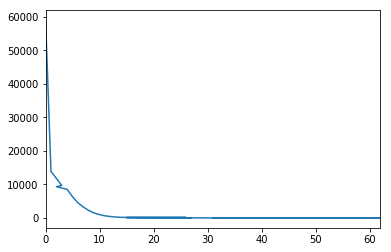

In [52]:

dfp['Sectieaantal'].value_counts().plot()


## Bereken het gemiddeld aantal secties, de mediaan, en de standaard deviatie, en geef de titel van (een?) pagina met het maximale aantal secties, en geef dat maximale aantal natuurlijk.

In [31]:
print('gemiddelde',dfp['Sectieaantal'].mean(),'mediaan',dfp['Sectieaantal'].median(),'standaard deviatie',pd.DataFrame.std(dfp['Sectieaantal']))

gemiddelde 2.1063598567488575 mediaan 1.0 standaard deviatie 3.592110071664292


In [53]:
print('De titel met het maximale aantal secties, is lijst van balletten met 402 secties',dfp.loc[dfp['Sectieaantal'].argmax()])

De titel met het maximale aantal secties, is lijst van balletten met 402 secties Pagetitel                                      Lijst van balletten
Sectieaantal                                                   402
Sectienaam       [ A ,  [[Komei Abe]] ,  [[Jean Absil]] ,  [[Ad...
Woordaantal                                                  11063
woordensectie                                              27.5199
aantal                                                         NaN
Name: 215903, dtype: object


## 8 Plot het aantal secties tegen het aantal woorden en bereken de correlatie.

0.23977784660853715

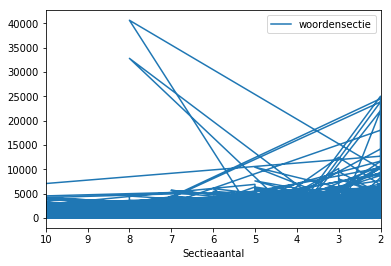

In [59]:
dfp.plot(x='Sectieaantal',y='woordensectie')
dfp['Sectieaantal'].corr(dfp['woordensectie'])


## Wat is het gemiddeld aantal woorden per sectie op NL Wikipedia? Geef eerst een sluitende definitie in woorden van dit begrip. En programmeer die dan. Wees niet te snel blij en klaar. Dit is nog best tricky.

Het gemiddeld aantal woorden per sectie is het aantal woorden van een pagina gedeeld door het aantal secties van diezelfde pagina

In [61]:
dfp['woordensectie'] = dfp['Woordaantal']  / dfp['Sectieaantal']
dfp.head()

,Pagetitel,Sectieaantal,Sectienaam,Woordaantal,woordensectie,aantal
1,Albert Speer,10,"[ Voor 1933 , Architect in dienst van Hitler ...",4864,486.40,13880.0
2,Andre Agassi,5,"[ Biografie , Palmares , Onderscheidingen , ...",22053,4410.60,9314.0
5,Groen (partij),5,"[ Geschiedenis , Structuur , Politieke manda...",6068,1213.60,6320.0
6,Anthony Fokker,4,"[ Levensloop , Trivia , Bibliografie , Exte...",1571,392.75,4491.0
7,Albert Plesman,4,"[Levensloop, Eerbewijzen, Diversen, Zijn gezin]",1746,436.50,3256.0


In [66]:
dfp = dfp.replace([np.inf, -np.inf], 0)
dfp.head()
dfp['woordensectie'].mean()

207.6780293148639

       country  year        pop continent  lifeExp   gdpPercap
0  Afghanistan  1952  8425333.0      Asia   28.801  779.445314
1  Afghanistan  1957  9240934.0      Asia   30.332  820.853030


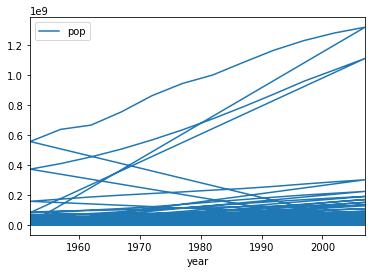

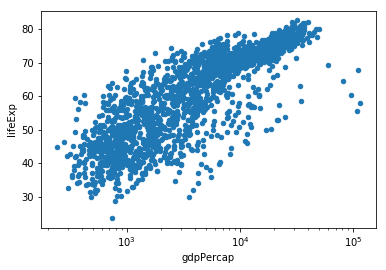

In [8]:
# Voorbeeld plot code  # Haal dit uit je antwoorden
import pandas as pd
%matplotlib inline
df = pd.read_csv('http://www.stat.ubc.ca/~jenny/notOcto/STAT545A/examples/gapminder/data/gapminderDataFiveYear.txt', sep='\t')
df2007 = df[df.year==2007]
df1952 = df[df.year==1952]
print (df.head(2))

df.plot(x='year', y='pop');

df.plot.scatter(x='gdpPercap', y='lifeExp', logx=True); # upgrade to pandas 17.0

In [9]:
t = 'fdsfsd'
h = 'sadsa'
l = 321
k = ['dsf', 'dsfsfds']
lel = {}
lel[2] = [t,h,l,k]
lel[1] = [t,h,l,k]
dfwordcount = pd.DataFrame.from_dict(lel,orient='index')
dfwordcount

,0,1,2,3
2,fdsfsd,sadsa,321,"[dsf, dsfsfds]"
1,fdsfsd,sadsa,321,"[dsf, dsfsfds]"


In [10]:
word_tokenize

NameError: name 'word_tokenize' is not defined